# Visualising the importance of various features for translation quality

### **Background to this notebook** 
+ Various tools like Quest++ and Bicleaner will output estimates of MT quality in the form of scores. 
+ Regardless of how the scores are calculated or which tool is used, it is important to be able to understand why a certain sentence pair is rated poorly or highly. 
+ Quest++ has a feature extraction module that can extract linguistic features from source and target text. It can then use these features to train classifiers to categorise translations into various quality bins. However, you can also just use the feature extraction on its own. 


### **Objective**
+ We want to use extracted linguistic features, together with the output scores, and understand which are the most important features influencing MT score quality. 
+ For a given translation unit, we want to be able to at least roughly understand why it got a specific score. 


### **Approach**

To study how specific linguistic features ultimately affect MT quality scores, you need either:
+ A dataset of translations, composed of their features **AND a category label**, like 0 or 1 if they’re poor or good, or any number of finer grained categories (it seems hard to get these since this would be human-assessed)
+ A dataset of translations, composed of their features **AND a quality score**, e.g. like those output from Quest++ or Bicleaner or anything else really

    + *Ideally, Quest++ would export its Python models and I could look at their internals directly rather than doing this roundabout approach. This might be worth considering as a contribution to their library**

This notebook establishes a workflow for the first approach, but we're just playing around with toy data for the time being. Should be pretty much immediately transferable to real data though. 

## An overview of the data

Alex ran the Quest++ feature extractor on a small toy dataset. The data can be imported using the `pandas` library,  which is the most common way to handle tables of data (dataframes) in Python. To import the `pandas` library (calling it `pd` as an abbrebiation to save keystrokes) and use it to load the data, you can run:        

In [1]:
import pandas as pd

In [29]:
# load feature names 
features = pd.read_csv("/Users/administrator/Projects/quest/questplusplus-vanilla/quest_plus_plus_17features.csv", header=None)
features = features.T[0]

# load data
df = pd.read_csv("/Users/administrator/Projects/quest/questplusplus-vanilla/output/test/output.txt", 
                 sep='\t', names=features)

# take a look at data
df.head()

,Number of tokens in source,Number of tokens in target cand,Number of tokens in target ref,Average source token length,LM probability of source sentence,LM probability of target sentence,Target word to target hypothesis,Average translations per source word,Average translations per source word inverse frequency,Unigrams in quartile 1 source,Unigrams in quartile 4 source,Bigrams in quartile 1 source,Bigrams in quartile 4 source,Trigrams in quartile 1 source,Trigrams in quartile 4 source,Unigrams source sentence in corpus,Punctuation source,Punctuation target
0,10.0,6.0,4.900000,-28.9020,NaN,1.000000,158.1000,0.587960,0.0,0.900000,0.000000,0.444444,0.000000,0.125000,0.900000,0.0,0.0,NaN
1,0.0,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
2,2.0,2.0,7.000000,-104.0390,-74.3798,1.000000,8.5000,11.256455,0.5,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,NaN
3,20.0,12.0,4.300000,-54.1031,-54.7076,1.090909,136.2500,0.926292,0.1,0.800000,0.052632,0.368421,0.055556,0.055556,0.950000,0.0,0.0,NaN
4,19.0,2.0,3.736842,-49.6304,-43.2478,1.000000,275.6842,1.584328,0.0,0.842105,0.000000,0.444444,0.000000,0.117647,0.947368,2.0,0.0,NaN


In [199]:
# visualise some of the data
import plotly.plotly as py
import plotly.figure_factory as ff

fig = ff.create_scatterplotmatrix(df.drop(df.columns[3:15], axis=1), 
                                  diag='histogram', index='scores',
                                  height=800, width=800)
py.iplot(fig)

In [30]:
# get some high-level statistics of the data
df.describe()

,Number of tokens in source,Number of tokens in target cand,Number of tokens in target ref,Average source token length,LM probability of source sentence,LM probability of target sentence,Target word to target hypothesis,Average translations per source word,Average translations per source word inverse frequency,Unigrams in quartile 1 source,Unigrams in quartile 4 source,Bigrams in quartile 1 source,Bigrams in quartile 4 source,Trigrams in quartile 1 source,Trigrams in quartile 4 source,Unigrams source sentence in corpus,Punctuation source,Punctuation target
count,10.000000,10.000000,9.000000,9.000000,8.000000,10.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,10.000000,10.000000,0.0
mean,20.700000,11.600000,4.585037,-62.498869,-55.295473,1.001890,163.481524,2.385863,0.075158,0.793536,0.008493,0.297827,0.006173,0.083381,0.935287,1.200000,0.700000,NaN
std,14.832772,15.305772,1.049911,25.318609,12.628555,0.389187,79.202782,3.352040,0.162847,0.130990,0.018329,0.156339,0.018519,0.051554,0.066925,1.316561,1.159502,NaN
min,0.000000,0.000000,3.619048,-104.039000,-74.379800,0.000000,8.500000,0.587960,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,NaN
25%,12.250000,2.000000,3.791168,-69.212600,-61.268150,1.000000,136.250000,0.945668,0.000000,0.775214,0.000000,0.200000,0.000000,0.055556,0.900000,0.000000,0.000000,NaN
50%,19.500000,6.000000,4.300000,-54.103100,-53.309366,1.035714,158.100000,1.559599,0.000000,0.838710,0.000000,0.320028,0.000000,0.068966,0.947368,1.000000,0.000000,NaN
75%,28.500000,14.250000,4.900000,-49.630400,-44.543200,1.106061,215.245860,1.683649,0.044160,0.896825,0.000000,0.444444,0.000000,0.117647,1.000000,2.000000,1.500000,NaN
max,46.000000,51.000000,7.000000,-28.902000,-42.596250,1.545454,275.684200,11.256455,0.500000,0.904762,0.052632,0.480882,0.055556,0.172697,1.000000,3.000000,3.000000,NaN


This shows some summary statistics of each feature column in the dataset. 

Some maybe non-obvious things:
+ count = the number of non-missing (NaN) values present in the column)
+ std = standard deviation
+ 25%, 50% (median), 75% = quartiles of the data. E.g. if the 50th percentile "Number of tokens in source" is 12.25, then half of the data is has a lower value for this feature, and half of the data has a higher value for it. 


## Generate some fake scores

I don't have scores yet, will simulate some.

In [200]:
import numpy as np

Numpy is the core Python library for numerical computation. 

In [201]:
# how many values do we need to generate/simulate/sample? As many as there are rows of data. 
print("Shape (rows and columns) of the dataframe: {0}".format(df.shape))
print("Number of rows in dataframe: {0}".format(df.shape[0]))
n_rows = df.shape[0]

Shape (rows and columns) of the dataframe: (9, 19)
Number of rows in dataframe: 9


In [202]:
# generate n random values between 0 and 1
simulated_scores = np.random.random(n_rows)
simulated_scores

array([0.22347702, 0.8706795 , 0.08393703, 0.77537931, 0.79722861,
       0.60063068, 0.73508702, 0.22815436, 0.55070838])

In [203]:
# generate some random labels
simulated_labels = np.random.choice([0,1], n_rows)
simulated_labels 

array([0, 0, 0, 1, 0, 0, 1, 0, 0])

In [204]:
# make new column in dataframe with these values as faux scores
df['scores'] = simulated_scores
df['labels'] = simulated_labels
df.head()

,Number of tokens in source,Number of tokens in target cand,Number of tokens in target ref,Average source token length,LM probability of source sentence,LM probability of target sentence,Target word to target hypothesis,Average translations per source word,Average translations per source word inverse frequency,Unigrams in quartile 1 source,Unigrams in quartile 4 source,Bigrams in quartile 1 source,Bigrams in quartile 4 source,Trigrams in quartile 1 source,Trigrams in quartile 4 source,Unigrams source sentence in corpus,Punctuation source,scores,labels
0,10.0,6.0,4.900000,-28.9020,-55.295473,1.000000,158.1000,0.587960,0.0,0.900000,0.000000,0.444444,0.000000,0.125000,0.900000,0.0,0.0,0.223477,0
2,2.0,2.0,7.000000,-104.0390,-74.379800,1.000000,8.5000,11.256455,0.5,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.870680,0
3,20.0,12.0,4.300000,-54.1031,-54.707600,1.090909,136.2500,0.926292,0.1,0.800000,0.052632,0.368421,0.055556,0.055556,0.950000,0.0,0.0,0.083937,0
4,19.0,2.0,3.736842,-49.6304,-43.247800,1.000000,275.6842,1.584328,0.0,0.842105,0.000000,0.444444,0.000000,0.117647,0.947368,2.0,0.0,0.775379,1
5,21.0,15.0,3.619048,-69.2126,-57.263200,1.071428,238.4762,1.683649,0.0,0.904762,0.000000,0.200000,0.000000,0.105263,1.000000,2.0,2.0,0.797229,0


## Handle missing values

You basically always have to handle the missing `NaN` values in your data before doing any sort of modelling. 

In [38]:
# check number of NaN values by column
df.isna().sum(axis=0)

Number of tokens in source                                 0
Number of tokens in target cand                            0
Number of tokens in target ref                             1
Average source token length                                1
LM probability of source sentence                          2
LM probability of target sentence                          0
Target word to target hypothesis                           1
Average translations per source word                       1
Average translations per source word inverse frequency     1
Unigrams in quartile 1 source                              1
Unigrams in quartile 4 source                              1
Bigrams in quartile 1 source                               1
Bigrams in quartile 4 source                               1
Trigrams in quartile 1 source                              1
Trigrams in quartile 4 source                              1
Unigrams source sentence in corpus                         0
Punctuation source      

In [39]:
# check for troublestome rows
df.isna().sum(axis=1)

0     2
1    13
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
dtype: int64

Looks like row 1 doesn't have a lot of information (it has 13 missing values), so we can just get rid of it. 


In [40]:
df = df.drop(1, axis=0)
df.head()

,Number of tokens in source,Number of tokens in target cand,Number of tokens in target ref,Average source token length,LM probability of source sentence,LM probability of target sentence,Target word to target hypothesis,Average translations per source word,Average translations per source word inverse frequency,Unigrams in quartile 1 source,Unigrams in quartile 4 source,Bigrams in quartile 1 source,Bigrams in quartile 4 source,Trigrams in quartile 1 source,Trigrams in quartile 4 source,Unigrams source sentence in corpus,Punctuation source,Punctuation target,scores,labels
0,10.0,6.0,4.900000,-28.9020,NaN,1.000000,158.1000,0.587960,0.0,0.900000,0.000000,0.444444,0.000000,0.125000,0.900000,0.0,0.0,NaN,0.419990,0
2,2.0,2.0,7.000000,-104.0390,-74.3798,1.000000,8.5000,11.256455,0.5,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,NaN,0.655582,0
3,20.0,12.0,4.300000,-54.1031,-54.7076,1.090909,136.2500,0.926292,0.1,0.800000,0.052632,0.368421,0.055556,0.055556,0.950000,0.0,0.0,NaN,0.715936,0
4,19.0,2.0,3.736842,-49.6304,-43.2478,1.000000,275.6842,1.584328,0.0,0.842105,0.000000,0.444444,0.000000,0.117647,0.947368,2.0,0.0,NaN,0.732217,1
5,21.0,15.0,3.619048,-69.2126,-57.2632,1.071428,238.4762,1.683649,0.0,0.904762,0.000000,0.200000,0.000000,0.105263,1.000000,2.0,2.0,NaN,0.332689,1


Column "Punctuation target" also has many NaN values; drop it:

In [41]:
df = df.drop(['Punctuation target'], axis=1)
df.head()

,Number of tokens in source,Number of tokens in target cand,Number of tokens in target ref,Average source token length,LM probability of source sentence,LM probability of target sentence,Target word to target hypothesis,Average translations per source word,Average translations per source word inverse frequency,Unigrams in quartile 1 source,Unigrams in quartile 4 source,Bigrams in quartile 1 source,Bigrams in quartile 4 source,Trigrams in quartile 1 source,Trigrams in quartile 4 source,Unigrams source sentence in corpus,Punctuation source,scores,labels
0,10.0,6.0,4.900000,-28.9020,NaN,1.000000,158.1000,0.587960,0.0,0.900000,0.000000,0.444444,0.000000,0.125000,0.900000,0.0,0.0,0.419990,0
2,2.0,2.0,7.000000,-104.0390,-74.3798,1.000000,8.5000,11.256455,0.5,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.655582,0
3,20.0,12.0,4.300000,-54.1031,-54.7076,1.090909,136.2500,0.926292,0.1,0.800000,0.052632,0.368421,0.055556,0.055556,0.950000,0.0,0.0,0.715936,0
4,19.0,2.0,3.736842,-49.6304,-43.2478,1.000000,275.6842,1.584328,0.0,0.842105,0.000000,0.444444,0.000000,0.117647,0.947368,2.0,0.0,0.732217,1
5,21.0,15.0,3.619048,-69.2126,-57.2632,1.071428,238.4762,1.683649,0.0,0.904762,0.000000,0.200000,0.000000,0.105263,1.000000,2.0,2.0,0.332689,1


In [53]:
# fill remaining NaNs with means
df = df.fillna(df.mean())

# Modelling feature importance with a random forest

In [55]:
# grab feature importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [57]:
X = df.drop(['scores', 'labels'], axis=1)
y = df['labels']

# ideally split data in train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [140]:
# instantiate model 
clf = RandomForestClassifier(n_estimators=100, max_depth=5)

# fit model, using features to predict class
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

The fitted RF model has internal feature importance parameters:

In [141]:
importances = clf.feature_importances_
importances

array([0.06841071, 0.01646429, 0.06854286, 0.07304286, 0.04765   ,
       0.03835714, 0.04339286, 0.08866071, 0.11311429, 0.08834524,
       0.04196429, 0.02983333, 0.01      , 0.12603571, 0.0573131 ,
       0.03524762, 0.033625  ])

To associate these values with actual features:

In [142]:
feature_indices = np.argsort(importances)[::-1]
feature_importances = pd.DataFrame(list(zip(X.columns[feature_indices], importances)), 
                                   columns = ['feature', 'relative_importance'])
feature_importances = feature_importances.sort_values(by='relative_importance', ascending=False)
feature_importances

,feature,relative_importance
13,Punctuation source,0.126036
8,LM probability of source sentence,0.113114
7,Trigrams in quartile 4 source,0.088661
9,Target word to target hypothesis,0.088345
3,Unigrams in quartile 1 source,0.073043
2,Average translations per source word,0.068543
0,Trigrams in quartile 1 source,0.068411
14,Bigrams in quartile 1 source,0.057313
4,Average source token length,0.047650
6,Number of tokens in source,0.043393


We can visualise these with a simple bar plot:

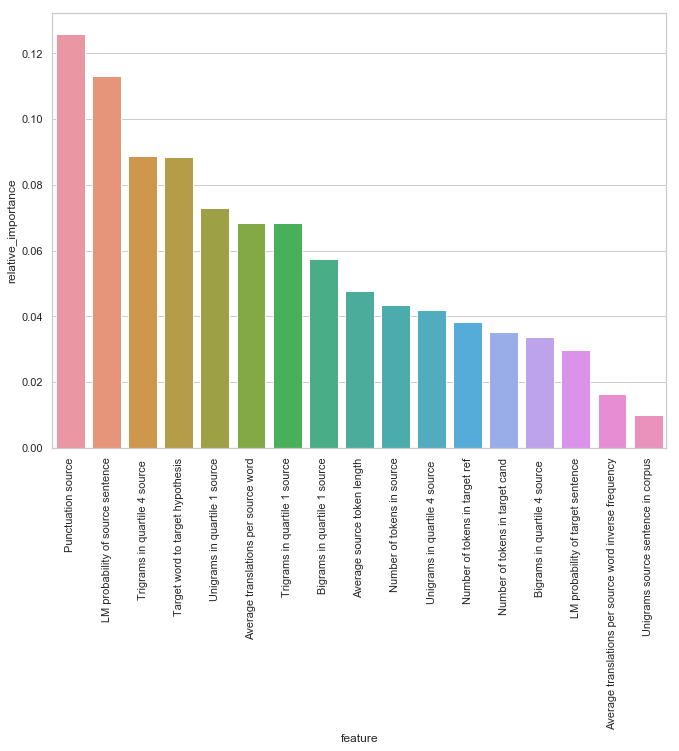

In [162]:
import seaborn as sns

# simple seaborn barplot 
sns.set(rc={'figure.figsize':(11,8)})
with sns.axes_style("whitegrid"):
    g = sns.barplot(x='feature', y='relative_importance', data=feature_importances)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)

Or as an interactive plotly chart:

In [144]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Bar(x=feature_importances.feature,
               y=feature_importances.relative_importance)]

py.iplot(data)

# Visualising tree logic in the RF

It's possible to visualise what decisions each classifier tree takes within a random forest ensemble.

In [154]:
from sklearn.tree import export_graphviz
from subprocess import check_call
from IPython.display import Image

def visualise_tree(classifier, estimator_index, features, labels, out_file='tree'):
    """
    Function to visualise a single tree's decision logic within an RF ensemble.
    """
    # grab a single tree, say the first one
    estimator = classifier.estimators_[estimator_index]

    # export as dot file
    dot_file = out_file+'.dot'
    export_graphviz(estimator, 
                    out_file = dot_file, 
                    feature_names = list(X.columns),
                    class_names = str(y),
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # convert to png
    png_file = out_file+'.png'
    check_call(['dot','-Tpng', dot_file,'-o', png_file])

    # import back .png
    return(Image(filename = png_file))

I wrote this as a function, so feel free to choose any value between 0 and 200 below to see what each different tree has learnt:

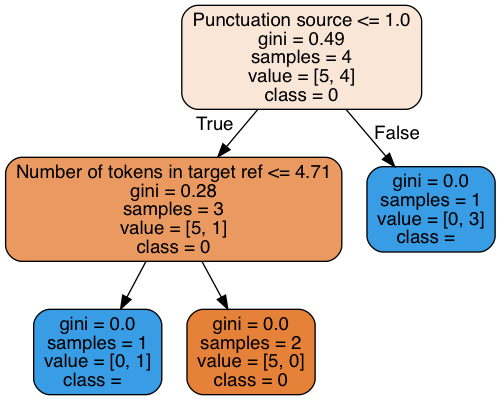

In [155]:
visualise_tree(clf, 0, list(X.columns), str(y), out_file='tree')

So, the first tree in the forest has learnt to split the data using a couple of different steps. First, is the punctuation score <= 1.0? If so, then examine number of tokens in the target reference sentence; otherwise, return class 1. 

Can examine a couple more:

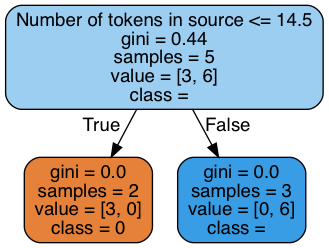

In [159]:
visualise_tree(clf, 1, list(X.columns), str(y), out_file='tree')

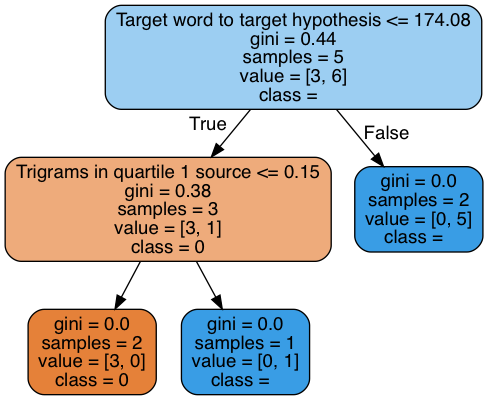

In [160]:
visualise_tree(clf, 2, list(X.columns), str(y), out_file='tree')